In [21]:
from transformers import AutoProcessor, AutoModelForCausalLM 
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

MODEL_ID = "microsoft/Florence-2-base"
FOOD_CATEGORIES = {
    'fruits': [
        'apple', 'banana', 'orange', 'grape', 'strawberry', 'blueberry', 'lime', 'lemon', 'cherry',
        'peach', 'pear', 'watermelon', 'pineapple', 'kiwi', 'mango', 'avocado', 'raspberry',
        'blackberry', 'cranberry', 'pomegranate', 'fig', 'date', 'plum', 'apricot', 'nectarine',
        'grapefruit', 'tangerine', 'clementine', 'lychee', 'guava', 'passion fruit', 'papaya',
        'dragon fruit', 'star fruit', 'persimmon', 'kumquat', 'elderberry', 'boysenberry',
        'mulberry', 'currant', 'gooseberry', 'plantain', 'coconut'
    ],
    'vegetables': [
        'tomato', 'cucumber', 'lettuce', 'carrot', 'broccoli', 'potato', 'onion', 'pepper',
        'spinach', 'cabbage', 'corn', 'peas', 'beans', 'celery', 'asparagus', 'artichoke',
        'brussels sprout', 'cauliflower', 'eggplant', 'zucchini', 'squash', 'pumpkin',
        'sweet potato', 'yam', 'radish', 'beet', 'turnip', 'parsnip', 'kale', 'collard greens',
        'mustard greens', 'swiss chard', 'bok choy', 'leek', 'scallion', 'garlic', 'ginger',
        'fennel', 'okra', 'endive', 'romaine lettuce', 'iceberg lettuce', 'arugula', 'watercress',
        'rhubarb', 'jicama', 'kohlrabi', 'sprouts', 'mushrooms' # Added mushrooms as a vegetable for culinary purposes
    ],
    'proteins': [
        'burger', 'chicken', 'beef', 'pork', 'fish', 'egg', 'cheese', 'milk', 'yogurt', 'meat',
        'salmon', 'tuna', 'cod', 'haddock', 'trout', 'sardine', 'mackerel', 'shrimp', 'crab',
        'lobster', 'oyster', 'mussel', 'clam', 'scallop', 'duck', 'turkey', 'lamb', 'venison',
        'bison', 'veal', 'sausage', 'bacon', 'ham', 'salami', 'pepperoni', 'tofu', 'tempeh',
        'edamame', 'lentils', 'chickpeas', 'black beans', 'kidney beans', 'lima beans', 'soybeans',
        'quinoa', 'cottage cheese', 'ricotta cheese', 'whey protein', 'casein protein'
    ],
    'grains': [
        'bread', 'rice', 'pasta', 'cereal', 'flour', 'oats', 'wheat', 'buckwheat', 'barley', 'rye',
        'cornmeal', 'couscous', 'millet', 'sorghum', 'farro', 'spelt', 'amaranth', 'quinoa',
        'grits', 'polenta', 'crackers', 'tortilla', 'naan', 'pita', 'bagel', 'croissant',
        'muffin', 'waffle', 'pancake', 'cornbread', 'rice noodles', 'soba noodles', 'udon noodles'
    ],
    'beverages': [
        'coffee', 'tea', 'juice', 'water', 'soda', 'wine', 'beer', 'milkshake', 'smoothie',
        'hot chocolate', 'cider', 'lemonade', 'iced tea', 'sports drink', 'energy drink',
        'seltzer', 'sparkling water', 'herbal tea', 'green tea', 'black tea', 'white tea',
        'oolong tea', 'espresso', 'latte', 'cappuccino', 'mocha', 'cola', 'root beer', 'ginger ale',
        'tonic water', 'club soda', 'vodka', 'whiskey', 'rum', 'gin', 'tequila', 'liqueur',
        'cocktail', 'kombucha'
    ],
    'sweets': [
        'cake', 'cookie', 'chocolate', 'candy', 'ice cream', 'donut', 'pie', 'brownie',
        'cupcake', 'muffin', 'pastry', 'pudding', 'gelato', 'sorbet', 'macaron', 'éclair',
        'cheesecake', 'tiramisu', 'crepe', 'waffle', 'pancake', 'caramel', 'fudge', 'marshmallow',
        'gummy bears', 'licorice', 'jelly beans', 'lollipop', 'toffee', 'nougat', 'marzipan',
        'honey', 'maple syrup', 'jam', 'jelly', 'marmalade', 'whipped cream', 'custard',
        'mousse', 'scone'
    ],
    'nuts_and_seeds': [ # Renamed to include seeds
        'almond', 'walnut', 'peanut', 'cashew', 'pistachio', 'pecan', 'hazelnut', 'macadamia nut',
        'brazil nut', 'pine nut', 'chia seed', 'flax seed', 'sesame seed', 'pumpkin seed',
        'sunflower seed', 'hemp seed', 'poppy seed', 'fennel seed', 'cumin seed', 'coriander seed'
    ],
    'spices_and_herbs': [
        'salt', 'pepper', 'sugar', 'garlic powder', 'onion powder', 'paprika', 'chili powder',
        'cumin', 'coriander', 'turmeric', 'ginger powder', 'cinnamon', 'nutmeg', 'clove',
        'cardamom', 'allspice', 'bay leaf', 'thyme', 'rosemary', 'oregano', 'basil', 'parsley',
        'dill', 'mint', 'sage', 'marjoram', 'tarragon', 'chives', 'cayenne pepper', 'red pepper flakes',
        'mustard seed', 'fennel seed', 'star anise', 'saffron', 'vanilla', 'curry powder'
    ],
    'oils_and_fats': [
        'olive oil', 'vegetable oil', 'canola oil', 'sunflower oil', 'coconut oil', 'butter',
        'margarine', 'lard', 'ghee', 'sesame oil', 'peanut oil', 'avocado oil', 'flaxseed oil',
        'cod liver oil', 'tallow'
    ],
    'condiments_and_sauces': [
        'ketchup', 'mayonnaise', 'mustard', 'soy sauce', 'barbecue sauce', 'hot sauce',
        'vinegar', 'salad dressing', 'relish', 'salsa', 'guacamole', 'hummus', 'pesto',
        'hollandaise sauce', 'tartar sauce', 'Worcestershire sauce', 'fish sauce', 'oyster sauce',
        'teriyaki sauce', 'sriracha', 'tabasco', 'chutney', 'aioli', 'marinara sauce',
        'alfredo sauce', 'gravy', 'syrup', 'molasses', 'agave nectar', 'tahini'
    ],
    'baked_goods': [ # Some overlap with 'grains' and 'sweets', but focuses on the prepared items
        'bread rolls', 'baguette', 'sourdough', 'rye bread', 'pita bread', 'naan bread',
        'croissant', 'danish', 'brioche', 'scone', 'biscotti', 'pretzels', 'bagels',
        'doughnuts', 'muffins', 'cupcakes', 'pies', 'tarts', 'quiche'
    ],
    'dairy_and_alternatives': [ # Expanded beyond just milk/cheese/yogurt
        'milk', 'cheese', 'yogurt', 'butter', 'cream', 'sour cream', 'buttermilk', 'kefir',
        'cottage cheese', 'ricotta cheese', 'cream cheese', 'mozzarella', 'cheddar', 'gouda',
        'brie', 'feta', 'parmesan', 'swiss cheese', 'goat cheese', 'soy milk', 'almond milk',
        'oat milk', 'rice milk', 'coconut milk', 'cashew milk', 'hemp milk', 'lactose-free milk',
        'plant-based yogurt', 'vegan cheese', 'ice cream' # Ice cream is also a dairy product
    ],
    'soups_and_stews': [
        'chicken noodle soup', 'tomato soup', 'vegetable soup', 'lentil soup', 'minestrone',
        'clam chowder', 'broccoli cheddar soup', 'french onion soup', 'gumbo', 'chili',
        'beef stew', 'lamb stew', 'irish stew', 'pot roast', 'bouillon', 'broth'
    ],
    'prepared_meals': [
        'pizza', 'sandwich', 'taco', 'burrito', 'sushi', 'burger', 'hot dog', 'pasta dish',
        'stir-fry', 'curry', 'lasagna', 'enchilada', 'quesadilla', 'fried chicken', 'roast chicken',
        'steak', 'ribs', 'meatloaf', 'casserole', 'dumplings', 'spring rolls', 'dim sum',
        'fish and chips', 'shepherd\'s pie', 'paella', 'risotto', 'paella', 'carbonara',
        'chow mein', 'fried rice', 'ramen', 'pho'
    ]
}


nutrition_data = {
    'apple': {'protein_g': 0.3, 'fat_g': 0.2, 'carbohydrates_g': 13.8},
    'banana': {'protein_g': 1.1, 'fat_g': 0.3, 'carbohydrates_g': 22.8},
    'orange': {'protein_g': 1.3, 'fat_g': 0.2, 'carbohydrates_g': 16.5},
    'grape': {'protein_g': 0.8, 'fat_g': 0.0, 'carbohydrates_g': 15.6},
    'strawberry': {'protein_g': 0.7, 'fat_g': 0.3, 'carbohydrates_g': 7.7},
    'blueberry': {'protein_g': 0.7, 'fat_g': 0.3, 'carbohydrates_g': 14.5},
    'lime': {'protein_g': 1.0, 'fat_g': 0.0, 'carbohydrates_g': 11.0},
    'lemon': {'protein_g': 1.1, 'fat_g': 0.3, 'carbohydrates_g': 9.3},
    'cherry': {'protein_g': 1.1, 'fat_g': 0.2, 'carbohydrates_g': 16.0},
    'peach': {'protein_g': 0.9, 'fat_g': 0.3, 'carbohydrates_g': 9.5},
    'pear': {'protein_g': 0.3, 'fat_g': 0.1, 'carbohydrates_g': 9.2},
    'watermelon': {'protein_g': 0.6, 'fat_g': 0.2, 'carbohydrates_g': 7.6},
    'pineapple': {'protein_g': 0.5, 'fat_g': 0.1, 'carbohydrates_g': 13.1},
    'kiwi': {'protein_g': 1.1, 'fat_g': 0.5, 'carbohydrates_g': 14.7},
    'mango': {'protein_g': 0.4, 'fat_g': 0.5, 'carbohydrates_g': 17.0},
    'avocado': {'protein_g': 2.0, 'fat_g': 14.7, 'carbohydrates_g': 8.5},
    'raspberry': {'protein_g': 1.2, 'fat_g': 0.7, 'carbohydrates_g': 11.9},
    'blackberry': {'protein_g': 1.1, 'fat_g': 0.7, 'carbohydrates_g': 6.5},
    'cranberry': {'protein_g': 0.5, 'fat_g': 0.1, 'carbohydrates_g': 12.0},
    'pomegranate': {'protein_g': 1.7, 'fat_g': 1.2, 'carbohydrates_g': 18.6},
    'fig': {'protein_g': 0.8, 'fat_g': 0.3, 'carbohydrates_g': 19.2},
    'date': {'protein_g': 2.0, 'fat_g': 0.2, 'carbohydrates_g': 75.0}, # Note: This is for dried dates, which is common
    'plum': {'protein_g': 0.7, 'fat_g': 0.3, 'carbohydrates_g': 11.4},
    'apricot': {'protein_g': 1.4, 'fat_g': 0.4, 'carbohydrates_g': 11.1},
    'nectarine': {'protein_g': 0.8, 'fat_g': 0.0, 'carbohydrates_g': 9.0},
    'grapefruit': {'protein_g': 0.8, 'fat_g': 0.1, 'carbohydrates_g': 10.7},
    'tangerine': {'protein_g': 0.8, 'fat_g': 0.3, 'carbohydrates_g': 13.3},
    'clementine': {'protein_g': 0.9, 'fat_g': 0.2, 'carbohydrates_g': 12.0},
    'lychee': {'protein_g': 0.8, 'fat_g': 0.4, 'carbohydrates_g': 16.5},
    'guava': {'protein_g': 2.6, 'fat_g': 1.0, 'carbohydrates_g': 14.3},
    'passion fruit': {'protein_g': 2.1, 'fat_g': 3.0, 'carbohydrates_g': 10.9},
    'papaya': {'protein_g': 0.5, 'fat_g': 0.3, 'carbohydrates_g': 11.0},
    'dragon fruit': {'protein_g': 1.2, 'fat_g': 0.0, 'carbohydrates_g': 13.0},
    'star fruit': {'protein_g': 1.0, 'fat_g': 0.3, 'carbohydrates_g': 6.7},
    'persimmon': {'protein_g': 0.2, 'fat_g': 0.1, 'carbohydrates_g': 8.4},
    'kumquat': {'protein_g': 1.9, 'fat_g': 0.9, 'carbohydrates_g': 15.9},
    'elderberry': {'protein_g': 0.7, 'fat_g': 0.1, 'carbohydrates_g': 18.4}, # Note: This is for fresh elderberries
    'boysenberry': {'protein_g': 1.0, 'fat_g': 0.0, 'carbohydrates_g': 12.0},
    'mulberry': {'protein_g': 1.4, 'fat_g': 0.4, 'carbohydrates_g': 9.8}, # Note: This is for fresh mulberries
    'currant': {'protein_g': 1.1, 'fat_g': 0.0, 'carbohydrates_g': 4.4}, # Note: This is for redcurrants
    'gooseberry': {'protein_g': 1.0, 'fat_g': 1.0, 'carbohydrates_g': 10.0},
    'plantain': {'protein_g': 1.3, 'fat_g': 0.4, 'carbohydrates_g': 31.9},
    'coconut': {'protein_g': 3.3, 'fat_g': 33.5, 'carbohydrates_g': 15.2}, # Note: This is for coconut meat
    'tomato': {'protein_g': 0.9, 'fat_g': 0.2, 'carbohydrates_g': 3.9},
    'cucumber': {'protein_g': 0.7, 'fat_g': 0.1, 'carbohydrates_g': 3.6},
    'lettuce': {'protein_g': 1.4, 'fat_g': 0.2, 'carbohydrates_g': 2.9}, # Assuming common varieties like Romaine
    'carrot': {'protein_g': 0.9, 'fat_g': 0.2, 'carbohydrates_g': 9.6},
    'broccoli': {'protein_g': 2.8, 'fat_g': 0.4, 'carbohydrates_g': 5.2},
    'potato': {'protein_g': 2.0, 'fat_g': 0.1, 'carbohydrates_g': 17.5}, # Raw, peeled
    'onion': {'protein_g': 1.1, 'fat_g': 0.1, 'carbohydrates_g': 9.3},
    'pepper': {'protein_g': 1.0, 'fat_g': 0.3, 'carbohydrates_g': 6.0}, # Bell pepper (capsicum)
    'spinach': {'protein_g': 2.9, 'fat_g': 0.4, 'carbohydrates_g': 3.6},
    'cabbage': {'protein_g': 1.3, 'fat_g': 0.1, 'carbohydrates_g': 5.8}, # Green cabbage
    'corn': {'protein_g': 3.3, 'fat_g': 1.2, 'carbohydrates_g': 19.0}, # Sweet corn kernels
    'peas': {'protein_g': 5.4, 'fat_g': 0.4, 'carbohydrates_g': 14.5}, # Green peas
    'beans': {'protein_g': 2.1, 'fat_g': 0.2, 'carbohydrates_g': 6.9}, # Green beans (common string beans)
    'celery': {'protein_g': 0.7, 'fat_g': 0.2, 'carbohydrates_g': 3.0},
    'asparagus': {'protein_g': 2.2, 'fat_g': 0.2, 'carbohydrates_g': 3.9},
    'artichoke': {'protein_g': 3.3, 'fat_g': 0.2, 'carbohydrates_g': 10.5},
    'brussels sprout': {'protein_g': 3.4, 'fat_g': 0.3, 'carbohydrates_g': 9.0},
    'cauliflower': {'protein_g': 1.9, 'fat_g': 0.3, 'carbohydrates_g': 5.0},
    'eggplant': {'protein_g': 1.0, 'fat_g': 0.2, 'carbohydrates_g': 5.9},
    'zucchini': {'protein_g': 1.2, 'fat_g': 0.3, 'carbohydrates_g': 3.1},
    'squash': {'protein_g': 1.2, 'fat_g': 0.1, 'carbohydrates_g': 8.0}, # Generic winter squash (e.g., butternut)
    'pumpkin': {'protein_g': 1.0, 'fat_g': 0.1, 'carbohydrates_g': 6.5},
    'sweet potato': {'protein_g': 1.6, 'fat_g': 0.1, 'carbohydrates_g': 20.1},
    'yam': {'protein_g': 1.5, 'fat_g': 0.2, 'carbohydrates_g': 27.9},
    'radish': {'protein_g': 0.7, 'fat_g': 0.1, 'carbohydrates_g': 3.4},
    'beet': {'protein_g': 1.6, 'fat_g': 0.2, 'carbohydrates_g': 9.6},
    'turnip': {'protein_g': 0.9, 'fat_g': 0.1, 'carbohydrates_g': 6.4},
    'parsnip': {'protein_g': 1.2, 'fat_g': 0.3, 'carbohydrates_g': 18.0},
    'kale': {'protein_g': 4.3, 'fat_g': 0.9, 'carbohydrates_g': 8.8},
    'collard greens': {'protein_g': 3.0, 'fat_g': 0.6, 'carbohydrates_g': 6.1},
    'mustard greens': {'protein_g': 2.9, 'fat_g': 0.5, 'carbohydrates_g': 4.7},
    'swiss chard': {'protein_g': 1.8, 'fat_g': 0.2, 'carbohydrates_g': 3.7},
    'bok choy': {'protein_g': 1.5, 'fat_g': 0.2, 'carbohydrates_g': 2.2},
    'leek': {'protein_g': 1.5, 'fat_g': 0.3, 'carbohydrates_g': 14.2},
    'scallion': {'protein_g': 1.8, 'fat_g': 0.3, 'carbohydrates_g': 7.3},
    'garlic': {'protein_g': 6.4, 'fat_g': 0.5, 'carbohydrates_g': 33.1},
    'ginger': {'protein_g': 1.8, 'fat_g': 0.7, 'carbohydrates_g': 17.8},
    'fennel': {'protein_g': 1.2, 'fat_g': 0.2, 'carbohydrates_g': 7.3},
    'okra': {'protein_g': 1.9, 'fat_g': 0.2, 'carbohydrates_g': 7.5},
    'endive': {'protein_g': 1.3, 'fat_g': 0.2, 'carbohydrates_g': 3.4},
    'romaine lettuce': {'protein_g': 1.2, 'fat_g': 0.3, 'carbohydrates_g': 3.3},
    'iceberg lettuce': {'protein_g': 0.9, 'fat_g': 0.1, 'carbohydrates_g': 2.9},
    'arugula': {'protein_g': 2.5, 'fat_g': 0.7, 'carbohydrates_g': 3.7},
    'watercress': {'protein_g': 2.3, 'fat_g': 0.1, 'carbohydrates_g': 1.3},
    'rhubarb': {'protein_g': 0.6, 'fat_g': 0.2, 'carbohydrates_g': 4.5},
    'jicama': {'protein_g': 1.2, 'fat_g': 0.1, 'carbohydrates_g': 8.8},
    'kohlrabi': {'protein_g': 1.7, 'fat_g': 0.1, 'carbohydrates_g': 6.0},
    'sprouts': {'protein_g': 4.0, 'fat_g': 0.5, 'carbohydrates_g': 7.0}, # Generic mixed sprouts (e.g., alfalfa, mung bean)
    'mushrooms': {'protein_g': 3.1, 'fat_g': 0.3, 'carbohydrates_g': 3.3}, # White mushrooms (common button)
    'burger': {'protein_g': 20.0, 'fat_g': 15.0, 'carbohydrates_g': 0.0}, # Cooked ground beef patty (plain, 80/20 lean/fat)
    'chicken': {'protein_g': 31.0, 'fat_g': 3.6, 'carbohydrates_g': 0.0}, # Cooked chicken breast (skinless, boneless)
    'beef': {'protein_g': 26.0, 'fat_g': 15.0, 'carbohydrates_g': 0.0}, # Cooked lean beef (e.g., sirloin)
    'pork': {'protein_g': 27.0, 'fat_g': 14.0, 'carbohydrates_g': 0.0}, # Cooked pork loin
    'fish': {'protein_g': 20.0, 'fat_g': 5.0, 'carbohydrates_g': 0.0}, # General average for cooked white fish
    'egg': {'protein_g': 12.6, 'fat_g': 10.6, 'carbohydrates_g': 1.1}, # Whole boiled egg
    'cheese': {'protein_g': 25.0, 'fat_g': 33.0, 'carbohydrates_g': 1.3}, # Cheddar cheese (average)
    'milk': {'protein_g': 3.4, 'fat_g': 3.6, 'carbohydrates_g': 4.8}, # Whole milk (per 100ml, which is approx 100g)
    'yogurt': {'protein_g': 5.7, 'fat_g': 3.3, 'carbohydrates_g': 4.7}, # Plain whole milk yogurt
    'meat': {'protein_g': 25.0, 'fat_g': 10.0, 'carbohydrates_g': 0.0}, # General average for cooked lean meat
    'salmon': {'protein_g': 20.4, 'fat_g': 13.4, 'carbohydrates_g': 0.0}, # Cooked Atlantic salmon
    'tuna': {'protein_g': 29.0, 'fat_g': 1.0, 'carbohydrates_g': 0.0}, # Canned tuna in water, drained
    'cod': {'protein_g': 17.9, 'fat_g': 0.7, 'carbohydrates_g': 0.0}, # Cooked Atlantic cod
    'haddock': {'protein_g': 19.3, 'fat_g': 0.7, 'carbohydrates_g': 0.0}, # Cooked Haddock
    'trout': {'protein_g': 21.0, 'fat_g': 6.0, 'carbohydrates_g': 0.0}, # Cooked Rainbow Trout
    'sardine': {'protein_g': 24.6, 'fat_g': 11.5, 'carbohydrates_g': 0.0}, # Canned sardines in oil, drained
    'mackerel': {'protein_g': 18.6, 'fat_g': 13.9, 'carbohydrates_g': 0.0}, # Cooked Atlantic Mackerel
    'shrimp': {'protein_g': 24.0, 'fat_g': 0.3, 'carbohydrates_g': 0.0}, # Cooked shrimp
    'crab': {'protein_g': 19.0, 'fat_g': 2.0, 'carbohydrates_g': 0.0}, # Cooked blue crab
    'lobster': {'protein_g': 19.0, 'fat_g': 2.0, 'carbohydrates_g': 0.0}, # Cooked lobster
    'oyster': {'protein_g': 9.0, 'fat_g': 2.0, 'carbohydrates_g': 4.0}, # Cooked oysters
    'mussel': {'protein_g': 12.0, 'fat_g': 2.0, 'carbohydrates_g': 3.0}, # Cooked mussels
    'clam': {'protein_g': 13.0, 'fat_g': 1.0, 'carbohydrates_g': 5.0}, # Cooked clams
    'scallop': {'protein_g': 23.0, 'fat_g': 0.5, 'carbohydrates_g': 3.0}, # Cooked scallops
    'duck': {'protein_g': 23.5, 'fat_g': 10.0, 'carbohydrates_g': 0.0}, # Cooked duck meat (skinless)
    'turkey': {'protein_g': 29.0, 'fat_g': 3.0, 'carbohydrates_g': 0.0}, # Cooked turkey breast (skinless)
    'lamb': {'protein_g': 25.0, 'fat_g': 16.0, 'carbohydrates_g': 0.0}, # Cooked lamb (e.g., leg)
    'venison': {'protein_g': 30.0, 'fat_g': 3.0, 'carbohydrates_g': 0.0}, # Cooked venison
    'bison': {'protein_g': 28.0, 'fat_g': 4.0, 'carbohydrates_g': 0.0}, # Cooked bison
    'veal': {'protein_g': 28.0, 'fat_g': 4.0, 'carbohydrates_g': 0.0}, # Cooked lean veal
    'sausage': {'protein_g': 15.0, 'fat_g': 25.0, 'carbohydrates_g': 2.0}, # Pork sausage, cooked (average)
    'bacon': {'protein_g': 27.0, 'fat_g': 45.0, 'carbohydrates_g': 0.0}, # Pan-fried streaky bacon
    'ham': {'protein_g': 18.0, 'fat_g': 10.0, 'carbohydrates_g': 1.0}, # Cooked lean ham
    'salami': {'protein_g': 22.0, 'fat_g': 35.0, 'carbohydrates_g': 1.5}, # Dry cured salami
    'pepperoni': {'protein_g': 20.0, 'fat_g': 50.0, 'carbohydrates_g': 1.0}, # Pepperoni slices
    'tofu': {'protein_g': 8.0, 'fat_g': 4.8, 'carbohydrates_g': 1.9}, # Firm tofu
    'tempeh': {'protein_g': 19.0, 'fat_g': 10.8, 'carbohydrates_g': 7.6},
    'edamame': {'protein_g': 11.9, 'fat_g': 5.2, 'carbohydrates_g': 10.2}, # Shelled, cooked
    'lentils': {'protein_g': 9.0, 'fat_g': 0.4, 'carbohydrates_g': 20.0}, # Cooked lentils
    'chickpeas': {'protein_g': 8.9, 'fat_g': 2.6, 'carbohydrates_g': 27.4}, # Cooked chickpeas
    'black beans': {'protein_g': 8.9, 'fat_g': 0.5, 'carbohydrates_g': 23.7}, # Cooked black beans
    'kidney beans': {'protein_g': 8.7, 'fat_g': 0.5, 'carbohydrates_g': 22.8}, # Cooked kidney beans
    'lima beans': {'protein_g': 6.8, 'fat_g': 0.4, 'carbohydrates_g': 19.6}, # Cooked lima beans
    'soybeans': {'protein_g': 18.2, 'fat_g': 17.3, 'carbohydrates_g': 10.7}, # Cooked soybeans
    'quinoa': {'protein_g': 14.1, 'fat_g': 6.1, 'carbohydrates_g': 64.2}, # Dry quinoa (before cooking, as this is a common purchase form)
    'cottage cheese': {'protein_g': 11.0, 'fat_g': 4.3, 'carbohydrates_g': 3.4}, # 4% fat cottage cheese
    'ricotta cheese': {'protein_g': 11.0, 'fat_g': 7.0, 'carbohydrates_g': 3.0}, # Whole milk ricotta
    'whey protein': {'protein_g': 75.0, 'fat_g': 5.0, 'carbohydrates_g': 8.0}, # Typical unflavored whey protein concentrate
    'casein protein': {'protein_g': 80.0, 'fat_g': 2.0, 'carbohydrates_g': 5.0}, # Typical unflavored casein protein powder
    'bread': {'protein_g': 9.0, 'fat_g': 1.0, 'carbohydrates_g': 46.0}, # White bread average
    'rice': {'protein_g': 2.7, 'fat_g': 0.3, 'carbohydrates_g': 28.2}, # Cooked white rice
    'pasta': {'protein_g': 5.8, 'fat_g': 0.9, 'carbohydrates_g': 30.6}, # Cooked spaghetti
    'cereal': {'protein_g': 7.0, 'fat_g': 0.9, 'carbohydrates_g': 84.0}, # Dry corn flakes (example)
    'flour': {'protein_g': 10.3, 'fat_g': 1.0, 'carbohydrates_g': 76.3}, # All-purpose white flour
    'oats': {'protein_g': 16.9, 'fat_g': 6.9, 'carbohydrates_g': 66.3}, # Dry rolled oats
    'wheat': {'protein_g': 13.7, 'fat_g': 2.5, 'carbohydrates_g': 71.2}, # Whole grain hard red wheat
    'buckwheat': {'protein_g': 13.3, 'fat_g': 3.4, 'carbohydrates_g': 71.5}, # Dry buckwheat groats
    'barley': {'protein_g': 12.5, 'fat_g': 2.3, 'carbohydrates_g': 73.5}, # Dry hulled barley
    'rye': {'protein_g': 10.3, 'fat_g': 1.6, 'carbohydrates_g': 69.8}, # Dry rye grain
    'cornmeal': {'protein_g': 7.0, 'fat_g': 5.0, 'carbohydrates_g': 87.0}, # Dry whole grain white cornmeal
    'couscous': {'protein_g': 5.7, 'fat_g': 1.0, 'carbohydrates_g': 51.3}, # Cooked couscous
    'millet': {'protein_g': 11.0, 'fat_g': 4.2, 'carbohydrates_g': 72.9}, # Dry millet
    'sorghum': {'protein_g': 11.3, 'fat_g': 3.3, 'carbohydrates_g': 74.6}, # Dry sorghum grain
    'farro': {'protein_g': 12.0, 'fat_g': 2.5, 'carbohydrates_g': 69.0}, # Dry farro
    'spelt': {'protein_g': 14.6, 'fat_g': 2.4, 'carbohydrates_g': 70.2}, # Dry spelt grain
    'amaranth': {'protein_g': 14.0, 'fat_g': 2.0, 'carbohydrates_g': 65.0}, # Dry amaranth grain
    'quinoa': {'protein_g': 14.1, 'fat_g': 6.1, 'carbohydrates_g': 64.2}, # Dry quinoa
    'grits': {'protein_g': 2.8, 'fat_g': 0.4, 'carbohydrates_g': 20.0}, # Cooked grits
    'polenta': {'protein_g': 2.4, 'fat_g': 0.6, 'carbohydrates_g': 14.4}, # Cooked polenta
    'crackers': {'protein_g': 7.3, 'fat_g': 16.4, 'carbohydrates_g': 70.7}, # Plain crackers
    'tortilla': {'protein_g': 7.0, 'fat_g': 3.0, 'carbohydrates_g': 45.0}, # Corn tortilla
    'naan': {'protein_g': 8.0, 'fat_g': 5.0, 'carbohydrates_g': 50.0}, # Plain naan bread
    'pita': {'protein_g': 9.0, 'fat_g': 1.0, 'carbohydrates_g': 55.0}, # White pita bread
    'bagel': {'protein_g': 10.0, 'fat_g': 2.0, 'carbohydrates_g': 49.0}, # Plain bagel
    'croissant': {'protein_g': 8.0, 'fat_g': 21.0, 'carbohydrates_g': 45.0}, # Butter croissant
    'muffin': {'protein_g': 5.0, 'fat_g': 15.0, 'carbohydrates_g': 50.0}, # Blueberry muffin (average)
    'waffle': {'protein_g': 6.0, 'fat_g': 10.0, 'carbohydrates_g': 30.0}, # Plain waffle (average)
    'pancake': {'protein_g': 5.0, 'fat_g': 10.0, 'carbohydrates_g': 25.0}, # Plain pancake (average)
    'cornbread': {'protein_g': 8.0, 'fat_g': 12.0, 'carbohydrates_g': 54.0}, # Cornbread (average)
    'rice noodles': {'protein_g': 1.0, 'fat_g': 0.2, 'carbohydrates_g': 20.0}, # Cooked rice noodles
    'soba noodles': {'protein_g': 5.0, 'fat_g': 0.5, 'carbohydrates_g': 25.0}, # Cooked soba noodles
    'udon noodles': {'protein_g': 3.0, 'fat_g': 0.5, 'carbohydrates_g': 21.0}, # Cooked udon noodles
        'coffee': {'protein_g': 0.1, 'fat_g': 0.1, 'carbohydrates_g': 0.0}, # Black coffee, brewed
    'tea': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0}, # Plain brewed tea (black/green)
    'juice': {'protein_g': 0.3, 'fat_g': 0.1, 'carbohydrates_g': 10.0}, # Average fruit juice (e.g., orange juice)
    'water': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'soda': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 10.0}, # Regular cola (average)
    'wine': {'protein_g': 0.1, 'fat_g': 0.0, 'carbohydrates_g': 2.6}, # Red wine (average)
    'beer': {'protein_g': 0.7, 'fat_g': 0.0, 'carbohydrates_g': 3.0}, # Regular beer (average)
    'milkshake': {'protein_g': 3.0, 'fat_g': 4.0, 'carbohydrates_g': 15.0}, # Vanilla milkshake (average)
    'smoothie': {'protein_g': 1.0, 'fat_g': 0.5, 'carbohydrates_g': 15.0}, # Fruit smoothie (average)
    'hot chocolate': {'protein_g': 3.0, 'fat_g': 3.0, 'carbohydrates_g': 15.0}, # Made with milk (average)
    'cider': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 8.0}, # Hard apple cider
    'lemonade': {'protein_g': 0.1, 'fat_g': 0.0, 'carbohydrates_g': 9.0}, # Sweetened lemonade
    'iced tea': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 7.0}, # Sweetened iced tea
    'sports drink': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 6.0}, # Isotonic sports drink
    'energy drink': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 11.0}, # Standard energy drink (e.g., Red Bull)
    'seltzer': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'sparkling water': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'herbal tea': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'green tea': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'black tea': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'white tea': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'oolong tea': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'espresso': {'protein_g': 0.1, 'fat_g': 0.1, 'carbohydrates_g': 0.0},
    'latte': {'protein_g': 3.0, 'fat_g': 3.0, 'carbohydrates_g': 5.0}, # Made with whole milk (average)
    'cappuccino': {'protein_g': 14.0, 'fat_g': 11.0, 'carbohydrates_g': 62.0}, # Instant cappuccino powder (high values due to powder form)
    'mocha': {'protein_g': 3.0, 'fat_g': 4.0, 'carbohydrates_g': 12.0}, # Made with milk and chocolate (average)
    'cola': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 10.0}, # Same as soda
    'root beer': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 11.0},
    'ginger ale': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 9.0},
    'tonic water': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 9.0},
    'club soda': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'vodka': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'whiskey': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'rum': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'gin': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'tequila': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'liqueur': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 20.0}, # Average sweet liqueur
    'cocktail': {'protein_g': 0.0, 'fat_g': 0.5, 'carbohydrates_g': 18.7}, # Mixed cocktail (average)
    'kombucha': {'protein_g': 0.1, 'fat_g': 0.1, 'carbohydrates_g': 3.0},
    'cake': {'protein_g': 5.0, 'fat_g': 17.0, 'carbohydrates_g': 56.0}, # Average cake
    'cookie': {'protein_g': 4.0, 'fat_g': 20.0, 'carbohydrates_g': 61.0}, # Sugar cookie average
    'chocolate': {'protein_g': 7.8, 'fat_g': 43.0, 'carbohydrates_g': 46.0}, # Dark chocolate (70-85% cocoa)
    'candy': {'protein_g': 1.0, 'fat_g': 12.0, 'carbohydrates_g': 75.0}, # General candy (high sugar)
    'ice cream': {'protein_g': 3.5, 'fat_g': 14.0, 'carbohydrates_g': 24.0}, # Vanilla ice cream
    'donut': {'protein_g': 4.0, 'fat_g': 15.0, 'carbohydrates_g': 40.0}, # Glazed donut
    'pie': {'protein_g': 3.0, 'fat_g': 15.0, 'carbohydrates_g': 35.0}, # Apple pie (average)
    'brownie': {'protein_g': 6.0, 'fat_g': 25.0, 'carbohydrates_g': 51.0},
    'cupcake': {'protein_g': 4.0, 'fat_g': 15.0, 'carbohydrates_g': 55.0}, # Average cupcake with frosting
    'muffin': {'protein_g': 5.0, 'fat_g': 15.0, 'carbohydrates_g': 50.0}, # (Repeated from grains, for consistency)
    'pastry': {'protein_g': 6.0, 'fat_g': 20.0, 'carbohydrates_g': 45.0}, # General sweet pastry (e.g., Danish)
    'pudding': {'protein_g': 3.0, 'fat_g': 4.0, 'carbohydrates_g': 20.0}, # Vanilla pudding (made with milk)
    'gelato': {'protein_g': 4.0, 'fat_g': 8.0, 'carbohydrates_g': 25.0}, # Vanilla gelato
    'sorbet': {'protein_g': 0.5, 'fat_g': 0.1, 'carbohydrates_g': 28.0}, # Fruit sorbet
    'macaron': {'protein_g': 6.0, 'fat_g': 18.0, 'carbohydrates_g': 65.0},
    'éclair': {'protein_g': 5.0, 'fat_g': 15.0, 'carbohydrates_g': 30.0},
    'cheesecake': {'protein_g': 5.0, 'fat_g': 21.0, 'carbohydrates_g': 30.0},
    'tiramisu': {'protein_g': 6.0, 'fat_g': 18.0, 'carbohydrates_g': 35.0},
    'crepe': {'protein_g': 8.8, 'fat_g': 11.3, 'carbohydrates_g': 22.0}, # Plain crepe
    'waffle': {'protein_g': 6.0, 'fat_g': 10.0, 'carbohydrates_g': 30.0}, # (Repeated from grains, for consistency)
    'pancake': {'protein_g': 5.0, 'fat_g': 10.0, 'carbohydrates_g': 25.0}, # (Repeated from grains, for consistency)
    'caramel': {'protein_g': 2.5, 'fat_g': 5.0, 'carbohydrates_g': 65.0}, # Caramel topping
    'fudge': {'protein_g': 3.0, 'fat_g': 17.0, 'carbohydrates_g': 65.0}, # Chocolate fudge
    'marshmallow': {'protein_g': 1.0, 'fat_g': 0.1, 'carbohydrates_g': 80.0},
    'gummy bears': {'protein_g': 6.0, 'fat_g': 0.0, 'carbohydrates_g': 77.0},
    'licorice': {'protein_g': 3.0, 'fat_g': 0.5, 'carbohydrates_g': 80.0}, # Black licorice
    'jelly beans': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 80.0},
    'lollipop': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 95.0},
    'toffee': {'protein_g': 2.0, 'fat_g': 15.0, 'carbohydrates_g': 75.0},
    'nougat': {'protein_g': 5.0, 'fat_g': 15.0, 'carbohydrates_g': 70.0},
    'marzipan': {'protein_g': 7.0, 'fat_g': 25.0, 'carbohydrates_g': 50.0},
    'honey': {'protein_g': 0.3, 'fat_g': 0.0, 'carbohydrates_g': 82.0},
    'maple syrup': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 67.0},
    'jam': {'protein_g': 0.5, 'fat_g': 0.1, 'carbohydrates_g': 60.0}, # Fruit jam
    'jelly': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 60.0}, # Fruit jelly (similar to jam, but no fruit pulp)
    'marmalade': {'protein_g': 0.5, 'fat_g': 0.1, 'carbohydrates_g': 60.0}, # Citrus marmalade
    'whipped cream': {'protein_g': 2.0, 'fat_g': 20.0, 'carbohydrates_g': 4.0}, # Sweetened, dairy
    'custard': {'protein_g': 4.0, 'fat_g': 3.0, 'carbohydrates_g': 17.0}, # Vanilla custard
    'mousse': {'protein_g': 4.0, 'fat_g': 15.0, 'carbohydrates_g': 20.0}, # Chocolate mousse
    'scone': {'protein_g': 7.0, 'fat_g': 12.0, 'carbohydrates_g': 50.0}, # Plain scone
    'almond': {'protein_g': 21.0, 'fat_g': 49.9, 'carbohydrates_g': 21.6},
    'walnut': {'protein_g': 15.2, 'fat_g': 65.2, 'carbohydrates_g': 13.7},
    'peanut': {'protein_g': 25.8, 'fat_g': 49.2, 'carbohydrates_g': 16.1},
    'cashew': {'protein_g': 18.2, 'fat_g': 43.9, 'carbohydrates_g': 26.9},
    'pistachio': {'protein_g': 20.2, 'fat_g': 45.3, 'carbohydrates_g': 27.5},
    'pecan': {'protein_g': 9.2, 'fat_g': 72.0, 'carbohydrates_g': 13.9},
    'hazelnut': {'protein_g': 15.0, 'fat_g': 61.0, 'carbohydrates_g': 17.0},
    'macadamia nut': {'protein_g': 7.9, 'fat_g': 75.8, 'carbohydrates_g': 13.8},
    'brazil nut': {'protein_g': 14.3, 'fat_g': 67.1, 'carbohydrates_g': 11.7},
    'pine nut': {'protein_g': 13.7, 'fat_g': 68.4, 'carbohydrates_g': 13.1},
    'chia seed': {'protein_g': 16.5, 'fat_g': 30.7, 'carbohydrates_g': 42.1},
    'flax seed': {'protein_g': 18.3, 'fat_g': 42.2, 'carbohydrates_g': 28.9},
    'sesame seed': {'protein_g': 17.7, 'fat_g': 49.7, 'carbohydrates_g': 23.4},
    'pumpkin seed': {'protein_g': 24.5, 'fat_g': 49.1, 'carbohydrates_g': 17.8},
    'sunflower seed': {'protein_g': 20.7, 'fat_g': 51.5, 'carbohydrates_g': 20.0},
    'hemp seed': {'protein_g': 30.0, 'fat_g': 49.0, 'carbohydrates_g': 9.0},
    'poppy seed': {'protein_g': 18.0, 'fat_g': 42.0, 'carbohydrates_g': 28.0},
    'fennel seed': {'protein_g': 15.8, 'fat_g': 14.9, 'carbohydrates_g': 52.3},
    'cumin seed': {'protein_g': 17.8, 'fat_g': 22.3, 'carbohydrates_g': 33.7},
    'coriander seed': {'protein_g': 12.4, 'fat_g': 17.8, 'carbohydrates_g': 13.1},
    'salt': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.0},
    'pepper': {'protein_g': 10.9, 'fat_g': 3.3, 'carbohydrates_g': 63.9}, # Black pepper, ground
    'sugar': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 100.0}, # Granulated sugar
    'garlic powder': {'protein_g': 16.7, 'fat_g': 0.7, 'carbohydrates_g': 73.0},
    'onion powder': {'protein_g': 10.0, 'fat_g': 0.5, 'carbohydrates_g': 70.0},
    'paprika': {'protein_g': 14.1, 'fat_g': 12.9, 'carbohydrates_g': 53.9},
    'chili powder': {'protein_g': 13.4, 'fat_g': 14.3, 'carbohydrates_g': 14.9}, # Red chili powder
    'cumin': {'protein_g': 17.8, 'fat_g': 22.3, 'carbohydrates_g': 33.7}, # Ground cumin
    'coriander': {'protein_g': 12.4, 'fat_g': 17.8, 'carbohydrates_g': 13.1}, # Ground coriander
    'turmeric': {'protein_g': 9.7, 'fat_g': 3.3, 'carbohydrates_g': 67.1}, # Ground turmeric
    'ginger powder': {'protein_g': 9.0, 'fat_g': 4.2, 'carbohydrates_g': 71.6}, # Ground ginger
    'cinnamon': {'protein_g': 3.8, 'fat_g': 29.0, 'carbohydrates_g': 4.0}, # Ground cinnamon (some sources show higher carbs, this is for a common spice)
    'nutmeg': {'protein_g': 6.0, 'fat_g': 36.0, 'carbohydrates_g': 49.0}, # Ground nutmeg
    'clove': {'protein_g': 6.0, 'fat_g': 13.0, 'carbohydrates_g': 65.5}, # Ground cloves
    'cardamom': {'protein_g': 11.0, 'fat_g': 7.0, 'carbohydrates_g': 68.0}, # Ground cardamom
    'allspice': {'protein_g': 6.0, 'fat_g': 9.0, 'carbohydrates_g': 72.0}, # Ground allspice
    'bay leaf': {'protein_g': 7.6, 'fat_g': 8.4, 'carbohydrates_g': 48.7}, # Dried bay leaf
    'thyme': {'protein_g': 9.1, 'fat_g': 7.4, 'carbohydrates_g': 63.9}, # Dried thyme
    'rosemary': {'protein_g': 4.9, 'fat_g': 15.2, 'carbohydrates_g': 64.6}, # Dried rosemary
    'oregano': {'protein_g': 9.0, 'fat_g': 4.3, 'carbohydrates_g': 64.4}, # Dried oregano
    'basil': {'protein_g': 23.0, 'fat_g': 4.0, 'carbohydrates_g': 48.0}, # Dried basil
    'parsley': {'protein_g': 26.6, 'fat_g': 4.4, 'carbohydrates_g': 50.6}, # Dried parsley
    'dill': {'protein_g': 3.5, 'fat_g': 1.1, 'carbohydrates_g': 7.0}, # Fresh dill weed
    'mint': {'protein_g': 3.8, 'fat_g': 0.6, 'carbohydrates_g': 8.0}, # Fresh mint leaves
    'sage': {'protein_g': 10.6, 'fat_g': 16.4, 'carbohydrates_g': 60.4}, # Dried sage
    'marjoram': {'protein_g': 12.9, 'fat_g': 7.0, 'carbohydrates_g': 60.6}, # Dried marjoram
    'tarragon': {'protein_g': 5.0, 'fat_g': 7.2, 'carbohydrates_g': 50.2}, # Dried tarragon
    'chives': {'protein_g': 3.3, 'fat_g': 0.7, 'carbohydrates_g': 4.4}, # Fresh chives
    'cayenne pepper': {'protein_g': 12.0, 'fat_g': 17.0, 'carbohydrates_g': 57.0}, # Ground cayenne pepper
    'red pepper flakes': {'protein_g': 12.0, 'fat_g': 17.0, 'carbohydrates_g': 57.0}, # Similar to cayenne
    'mustard seed': {'protein_g': 26.0, 'fat_g': 36.0, 'carbohydrates_g': 28.0}, # Whole mustard seeds
    'fennel seed': {'protein_g': 15.8, 'fat_g': 14.9, 'carbohydrates_g': 52.3},
    'star anise': {'protein_g': 17.6, 'fat_g': 15.9, 'carbohydrates_g': 50.0}, # Whole star anise
    'saffron': {'protein_g': 11.4, 'fat_g': 5.9, 'carbohydrates_g': 65.4},
    'vanilla': {'protein_g': 0.1, 'fat_g': 0.1, 'carbohydrates_g': 12.7}, # Vanilla extract (mostly water/alcohol)
    'curry powder': {'protein_g': 14.3, 'fat_g': 14.0, 'carbohydrates_g': 2.8},
    'olive oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'vegetable oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0}, # Generic blend
    'canola oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'sunflower oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'coconut oil': {'protein_g': 0.0, 'fat_g': 99.1, 'carbohydrates_g': 0.0},
    'butter': {'protein_g': 0.5, 'fat_g': 81.1, 'carbohydrates_g': 0.1},
    'margarine': {'protein_g': 0.4, 'fat_g': 80.0, 'carbohydrates_g': 0.5}, # Stick margarine
    'lard': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'ghee': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'sesame oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'peanut oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'avocado oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'flaxseed oil': {'protein_g': 0.1, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'cod liver oil': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'tallow': {'protein_g': 0.0, 'fat_g': 100.0, 'carbohydrates_g': 0.0},
    'ketchup': {'protein_g': 1.0, 'fat_g': 0.3, 'carbohydrates_g': 25.8},
    'mayonnaise': {'protein_g': 0.9, 'fat_g': 78.0, 'carbohydrates_g': 3.2},
    'mustard': {'protein_g': 4.0, 'fat_g': 4.0, 'carbohydrates_g': 10.0}, # Yellow mustard
    'soy sauce': {'protein_g': 8.1, 'fat_g': 0.1, 'carbohydrates_g': 5.1},
    'barbecue sauce': {'protein_g': 1.0, 'fat_g': 1.0, 'carbohydrates_g': 41.0},
    'hot sauce': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 21.0}, # Sriracha example
    'vinegar': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 0.9}, # White vinegar
    'salad dressing': {'protein_g': 0.5, 'fat_g': 20.0, 'carbohydrates_g': 10.0}, # Vinaigrette average
    'relish': {'protein_g': 0.5, 'fat_g': 0.1, 'carbohydrates_g': 20.0}, # Sweet pickle relish
    'salsa': {'protein_g': 1.0, 'fat_g': 0.3, 'carbohydrates_g': 8.0}, # Tomato salsa
    'guacamole': {'protein_g': 2.0, 'fat_g': 13.0, 'carbohydrates_g': 9.0},
    'hummus': {'protein_g': 8.0, 'fat_g': 10.0, 'carbohydrates_g': 14.0},
    'pesto': {'protein_g': 4.0, 'fat_g': 45.0, 'carbohydrates_g': 4.0}, # Basil pesto
    'hollandaise sauce': {'protein_g': 0.6, 'fat_g': 29.0, 'carbohydrates_g': 4.8},
    'tartar sauce': {'protein_g': 0.8, 'fat_g': 50.0, 'carbohydrates_g': 6.0},
    'Worcestershire sauce': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 19.0},
    'fish sauce': {'protein_g': 6.0, 'fat_g': 0.0, 'carbohydrates_g': 5.0},
    'oyster sauce': {'protein_g': 3.0, 'fat_g': 0.0, 'carbohydrates_g': 20.0},
    'teriyaki sauce': {'protein_g': 3.0, 'fat_g': 0.0, 'carbohydrates_g': 20.0},
    'sriracha': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 21.0},
    'tabasco': {'protein_g': 1.0, 'fat_g': 0.5, 'carbohydrates_g': 3.0},
    'chutney': {'protein_g': 0.8, 'fat_g': 0.2, 'carbohydrates_g': 60.0}, # Mango chutney (average)
    'aioli': {'protein_g': 0.1, 'fat_g': 43.8, 'carbohydrates_g': 1.0},
    'marinara sauce': {'protein_g': 1.5, 'fat_g': 2.0, 'carbohydrates_g': 8.0},
    'alfredo sauce': {'protein_g': 3.0, 'fat_g': 16.0, 'carbohydrates_g': 5.0},
    'gravy': {'protein_g': 2.0, 'fat_g': 3.0, 'carbohydrates_g': 12.0},
    'syrup': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 67.0}, # Simple syrup (sugar syrup)
    'molasses': {'protein_g': 0.0, 'fat_g': 0.1, 'carbohydrates_g': 75.0},
    'agave nectar': {'protein_g': 0.0, 'fat_g': 0.0, 'carbohydrates_g': 76.0},
    'tahini': {'protein_g': 17.0, 'fat_g': 54.0, 'carbohydrates_g': 21.0},
    'bread rolls': {'protein_g': 9.3, 'fat_g': 2.9, 'carbohydrates_g': 44.6}, # White bread roll
    'baguette': {'protein_g': 8.0, 'fat_g': 1.4, 'carbohydrates_g': 56.0},
    'sourdough': {'protein_g': 10.0, 'fat_g': 1.0, 'carbohydrates_g': 50.0}, # Sourdough bread
    'rye bread': {'protein_g': 9.0, 'fat_g': 2.0, 'carbohydrates_g': 45.0}, # Dark rye bread
    'pita bread': {'protein_g': 9.0, 'fat_g': 1.0, 'carbohydrates_g': 55.0}, # (Repeated from grains, for consistency)
    'naan bread': {'protein_g': 8.0, 'fat_g': 5.0, 'carbohydrates_g': 50.0}, # (Repeated from grains, for consistency)
    'croissant': {'protein_g': 8.0, 'fat_g': 21.0, 'carbohydrates_g': 45.0}, # (Repeated from sweets, for consistency)
    'danish': {'protein_g': 5.4, 'fat_g': 18.5, 'carbohydrates_g': 47.8}, # Danish pastry
    'brioche': {'protein_g': 8.0, 'fat_g': 10.0, 'carbohydrates_g': 36.0}, # Brioche bun
    'scone': {'protein_g': 7.0, 'fat_g': 12.0, 'carbohydrates_g': 50.0}, # (Repeated from sweets, for consistency)
    'biscotti': {'protein_g': 6.0, 'fat_g': 30.0, 'carbohydrates_g': 59.0},
    'pretzels': {'protein_g': 10.0, 'fat_g': 4.0, 'carbohydrates_g': 75.0}, # Hard pretzels
    'bagels': {'protein_g': 11.0, 'fat_g': 1.0, 'carbohydrates_g': 52.0}, # Plain bagel (average)
    'doughnuts': {'protein_g': 4.0, 'fat_g': 15.0, 'carbohydrates_g': 40.0}, # Glazed donut (average, repeated from sweets)
    'muffins': {'protein_g': 5.0, 'fat_g': 15.0, 'carbohydrates_g': 50.0}, # (Repeated from sweets, for consistency)
    'cupcakes': {'protein_g': 4.0, 'fat_g': 15.0, 'carbohydrates_g': 55.0}, # (Repeated from sweets, for consistency)
    'pies': {'protein_g': 3.0, 'fat_g': 15.0, 'carbohydrates_g': 35.0}, # (Repeated from sweets, for consistency)
    'tarts': {'protein_g': 4.0, 'fat_g': 18.0, 'carbohydrates_g': 30.0}, # Fruit tart (average)
    'quiche': {'protein_g': 10.0, 'fat_g': 15.0, 'carbohydrates_g': 15.0}, # Quiche Lorraine (average)
    'milk': {'protein_g': 3.4, 'fat_g': 3.6, 'carbohydrates_g': 4.8}, # Whole milk
    'cheese': {'protein_g': 25.0, 'fat_g': 33.0, 'carbohydrates_g': 1.3}, # Cheddar cheese (general)
    'yogurt': {'protein_g': 5.7, 'fat_g': 3.3, 'carbohydrates_g': 4.7}, # Plain whole milk yogurt
    'butter': {'protein_g': 0.5, 'fat_g': 81.1, 'carbohydrates_g': 0.1},
    'cream': {'protein_g': 2.0, 'fat_g': 40.0, 'carbohydrates_g': 2.7}, # Whipping cream (average)
    'sour cream': {'protein_g': 2.4, 'fat_g': 19.0, 'carbohydrates_g': 3.8}, # Regular sour cream
    'buttermilk': {'protein_g': 3.3, 'fat_g': 0.9, 'carbohydrates_g': 4.8},
    'kefir': {'protein_g': 3.8, 'fat_g': 3.5, 'carbohydrates_g': 4.0}, # Plain whole milk kefir
    'cottage cheese': {'protein_g': 11.0, 'fat_g': 4.3, 'carbohydrates_g': 3.4},
    'ricotta cheese': {'protein_g': 11.0, 'fat_g': 7.0, 'carbohydrates_g': 3.0},
    'cream cheese': {'protein_g': 6.0, 'fat_g': 34.0, 'carbohydrates_g': 5.0},
    'mozzarella': {'protein_g': 22.0, 'fat_g': 17.0, 'carbohydrates_g': 2.0}, # Whole milk mozzarella
    'cheddar': {'protein_g': 24.9, 'fat_g': 33.1, 'carbohydrates_g': 1.3},
    'gouda': {'protein_g': 24.9, 'fat_g': 27.4, 'carbohydrates_g': 2.2},
    'brie': {'protein_g': 20.8, 'fat_g': 27.7, 'carbohydrates_g': 0.5},
    'feta': {'protein_g': 14.0, 'fat_g': 21.0, 'carbohydrates_g': 4.0},
    'parmesan': {'protein_g': 35.8, 'fat_g': 25.8, 'carbohydrates_g': 3.2},
    'swiss cheese': {'protein_g': 27.0, 'fat_g': 27.0, 'carbohydrates_g': 1.4},
    'goat cheese': {'protein_g': 18.0, 'fat_g': 22.0, 'carbohydrates_g': 2.0},
    'soy milk': {'protein_g': 3.3, 'fat_g': 1.8, 'carbohydrates_g': 2.6}, # Unsweetened
    'almond milk': {'protein_g': 0.5, 'fat_g': 1.1, 'carbohydrates_g': 2.7}, # Unsweetened original
    'oat milk': {'protein_g': 1.0, 'fat_g': 1.5, 'carbohydrates_g': 6.5}, # Original unsweetened
    'rice milk': {'protein_g': 0.3, 'fat_g': 1.0, 'carbohydrates_g': 10.0}, # Original unsweetened
    'coconut milk': {'protein_g': 0.0, 'fat_g': 12.0, 'carbohydrates_g': 2.0}, # Canned (beverage type)
    'cashew milk': {'protein_g': 0.3, 'fat_g': 1.0, 'carbohydrates_g': 1.0}, # Unsweetened
    'hemp milk': {'protein_g': 0.7, 'fat_g': 3.0, 'carbohydrates_g': 0.0}, # Unsweetened
    'lactose-free milk': {'protein_g': 3.4, 'fat_g': 3.6, 'carbohydrates_g': 4.8}, # Similar to regular milk, just lactose-free
    'plant-based yogurt': {'protein_g': 1.0, 'fat_g': 2.0, 'carbohydrates_g': 10.0}, # Almond or soy based, unsweetened
    'vegan cheese': {'protein_g': 0.0, 'fat_g': 25.0, 'carbohydrates_g': 20.0}, # Average vegan cheddar style
    'ice cream': {'protein_g': 3.5, 'fat_g': 14.0, 'carbohydrates_g': 24.0}, # Vanilla ice cream (repeated for consistency)
    'chicken noodle soup': {'protein_g': 3.0, 'fat_g': 2.0, 'carbohydrates_g': 7.0}, # Canned, prepared
    'tomato soup': {'protein_g': 1.0, 'fat_g': 1.0, 'carbohydrates_g': 10.0}, # Canned, prepared with water
    'vegetable soup': {'protein_g': 1.5, 'fat_g': 0.5, 'carbohydrates_g': 6.0}, # Canned, prepared
    'lentil soup': {'protein_g': 4.0, 'fat_g': 1.0, 'carbohydrates_g': 12.0}, # Prepared
    'minestrone': {'protein_g': 2.5, 'fat_g': 1.0, 'carbohydrates_g': 10.0}, # Canned, prepared
    'clam chowder': {'protein_g': 7.0, 'fat_g': 2.0, 'carbohydrates_g': 10.0},
    'broccoli cheddar soup': {'protein_g': 7.0, 'fat_g': 6.0, 'carbohydrates_g': 8.0},
    'french onion soup': {'protein_g': 7.0, 'fat_g': 6.8, 'carbohydrates_g': 16.0}, # Prepared
    'gumbo': {'protein_g': 6.0, 'fat_g': 5.0, 'carbohydrates_g': 8.0}, # Chicken and sausage gumbo
    'chili': {'protein_g': 8.0, 'fat_g': 7.0, 'carbohydrates_g': 6.0}, # Chili with beans
    'beef stew': {'protein_g': 20.0, 'fat_g': 10.0, 'carbohydrates_g': 4.0},
    'lamb stew': {'protein_g': 15.0, 'fat_g': 10.0, 'carbohydrates_g': 8.0},
    'irish stew': {'protein_g': 10.0, 'fat_g': 8.0, 'carbohydrates_g': 12.0},
    'pot roast': {'protein_g': 15.0, 'fat_g': 8.0, 'carbohydrates_g': 5.0}, # As a prepared dish, not just meat
    'bouillon': {'protein_g': 0.5, 'fat_g': 0.5, 'carbohydrates_g': 0.1}, # Prepared (per 100ml)
    'broth': {'protein_g': 0.5, 'fat_g': 0.1, 'carbohydrates_g': 1.0}, # Prepared (per 100ml)
    'pizza': {'protein_g': 12.2, 'fat_g': 10.4, 'carbohydrates_g': 35.6}, # Cheese pizza, average
    'sandwich': {'protein_g': 10.0, 'fat_g': 8.0, 'carbohydrates_g': 25.0}, # Turkey and cheese sandwich, average
    'taco': {'protein_g': 10.0, 'fat_g': 10.0, 'carbohydrates_g': 20.0}, # Beef taco, hard shell, average
    'burrito': {'protein_g': 9.0, 'fat_g': 12.0, 'carbohydrates_g': 39.0}, # Beef and bean burrito
    'sushi': {'protein_g': 9.0, 'fat_g': 1.0, 'carbohydrates_g': 30.0}, # Nigiri (rice and fish)
    'burger': {'protein_g': 18.0, 'fat_g': 20.0, 'carbohydrates_g': 3.0}, # Plain beef patty (repeated for consistency)
    'hot dog': {'protein_g': 10.6, 'fat_g': 14.8, 'carbohydrates_g': 18.4}, # Hot dog sausage in bun
    'pasta dish': {'protein_g': 8.0, 'fat_g': 10.0, 'carbohydrates_g': 30.0}, # Generic pasta with sauce
    'stir-fry': {'protein_g': 8.0, 'fat_g': 5.0, 'carbohydrates_g': 15.0}, # Chicken and vegetable stir-fry
    'curry': {'protein_g': 11.8, 'fat_g': 17.6, 'carbohydrates_g': 23.5}, # Indian curry, average
    'lasagna': {'protein_g': 10.5, 'fat_g': 5.9, 'carbohydrates_g': 4.8}, # Beef lasagna
    'enchilada': {'protein_g': 10.0, 'fat_g': 12.0, 'carbohydrates_g': 26.0}, # Cheese enchilada
    'quesadilla': {'protein_g': 16.0, 'fat_g': 20.0, 'carbohydrates_g': 34.0}, # Cheese quesadilla
    'fried chicken': {'protein_g': 14.0, 'fat_g': 29.2, 'carbohydrates_g': 20.0}, # Breaded fried chicken
    'roast chicken': {'protein_g': 25.0, 'fat_g': 15.0, 'carbohydrates_g': 0.0}, # Roasted chicken meat (skin on)
    'steak': {'protein_g': 26.0, 'fat_g': 15.0, 'carbohydrates_g': 0.0}, # Cooked lean beef steak (repeated for consistency)
    'ribs': {'protein_g': 20.0, 'fat_g': 25.0, 'carbohydrates_g': 0.0}, # Pork ribs, cooked
    'meatloaf': {'protein_g': 20.0, 'fat_g': 15.0, 'carbohydrates_g': 10.0}, # Beef meatloaf
    'casserole': {'protein_g': 10.0, 'fat_g': 10.0, 'carbohydrates_g': 15.0}, # Generic casserole
    'dumplings': {'protein_g': 3.0, 'fat_g': 2.0, 'carbohydrates_g': 4.0}, # Boiled plain dumplings
    'spring rolls': {'protein_g': 8.0, 'fat_g': 15.0, 'carbohydrates_g': 25.0}, # Fried vegetable spring rolls
    'dim sum': {'protein_g': 8.0, 'fat_g': 7.0, 'carbohydrates_g': 20.0}, # Mixed dim sum (average)
    'fish and chips': {'protein_g': 15.0, 'fat_g': 20.0, 'carbohydrates_g': 30.0}, # Average portion
    'shepherd\'s pie': {'protein_g': 10.0, 'fat_g': 8.0, 'carbohydrates_g': 15.0},
    'paella': {'protein_g': 7.0, 'fat_g': 2.0, 'carbohydrates_g': 11.0}, # Seafood paella
    'risotto': {'protein_g': 5.0, 'fat_g': 8.0, 'carbohydrates_g': 20.0}, # Mushroom risotto
    'carbonara': {'protein_g': 7.5, 'fat_g': 9.6, 'carbohydrates_g': 10.4}, # Spaghetti Carbonara
    'chow mein': {'protein_g': 4.0, 'fat_g': 7.0, 'carbohydrates_g': 33.0},
    'fried rice': {'protein_g': 6.0, 'fat_g': 2.5, 'carbohydrates_g': 66.0},
    'ramen': {'protein_g': 5.0, 'fat_g': 3.0, 'carbohydrates_g': 15.0}, # Instant ramen, prepared
    'pho': {'protein_g': 6.1, 'fat_g': 2.2, 'carbohydrates_g': 10.4} # Beef pho
    
}


In [8]:
model = AutoModelForCausalLM.from_pretrained(MODEL_ID, \
    trust_remote_code = True).eval()
processor = AutoProcessor.from_pretrained(MODEL_ID, \
    trust_remote_code = True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [9]:
def inference(task_prompt, text_input = None, image_input = None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
        
    inputs = processor(text = prompt, images = image_input, return_tensors = "pt")\
        .to('cpu')
        
    generated_ids = model.generate(
        input_ids = inputs['input_ids'],
        pixel_values = inputs['pixel_values'],
        max_new_tokens = 1024,
        early_stopping = False,
    )
    
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens = False)[0]
    
    parsed_answer = processor.post_process_generation(
        generated_text,
        task = task_prompt,
        image_size = (image_input.width, image_input.height)
    )
    
    return parsed_answer

In [10]:
def convert_to_od_format(data):
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])
    
    od_results = {
        'bboxes': bboxes,
        'labels': labels,
    }
    
    return od_results

In [11]:
def plot_bbox(image, data):
    fig, ax = plt.subplots(figsize = (10, 10))
    
    ax.imshow(image)
    
    for bbox, label in zip(data['bboxes'], data['labels']):
        
        x1, y1, x2, y2 = bbox
        
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        
        plt.text(x1, y1, label, fontsize = 12, color = 'white', bbox = dict(facecolor = 'r', alpha = 0.5))
    
    plt.axis('off')
    plt.show()


In [12]:
def detect_foods(image):
    more_detailed_caption = '<MORE_DETAILED_CAPTION>'
    results_more_detailed_caption = inference(more_detailed_caption, image_input = image)
    description_of_the_image = results_more_detailed_caption[more_detailed_caption]
    
    foods_to_prompt = []
    for food_category in FOOD_CATEGORIES.values():
        for food in food_category:
            if food in description_of_the_image:
                foods_to_prompt.append(food)
                
    task_prompt = "<OPEN_VOCABULARY_DETECTION>"
    bboxes = {
        'bboxes': [],
        'labels': [],
    }
    for food in foods_to_prompt:
        results = inference(task_prompt, image_input = image, 
                            text_input= f'{food}')
        converted_results = convert_to_od_format(results[task_prompt])
        bboxes['bboxes'].extend(converted_results['bboxes'])
        bboxes['labels'].extend(converted_results['labels'])
        
    return bboxes

In [45]:
def get_nutrition(labels):
    foods_count = {
    
    }

    for label in labels:
        if label in foods_count:
            foods_count[label] += 1
        else:
            foods_count[label] = 1
            
    nutrition = {
        'protein_g': 0,
        'fat_g': 0,
        'carbohydrates_g': 0
    }
    nutrition_detailed = {
        'protein_g': {},
        'fat_g': {},
        'carbohydrates_g': {}
    }
    
    
    for food in foods_count:

        nutrition['protein_g'] += nutrition_data[food]['protein_g']
        nutrition['fat_g'] += nutrition_data[food]['fat_g']
        nutrition['carbohydrates_g'] += nutrition_data[food]['carbohydrates_g']
        
        if food in nutrition_detailed['protein_g']:
            nutrition_detailed['protein_g'][food] += nutrition_data[food]['protein_g']
        else:
            nutrition_detailed['protein_g'][food] = nutrition_data[food]['protein_g']
            
        if food in nutrition_detailed['fat_g']:
            nutrition_detailed['fat_g'][food] += nutrition_data[food]['fat_g']
        else:
            nutrition_detailed['fat_g'][food] = nutrition_data[food]['fat_g']
            
        if food in nutrition_detailed['carbohydrates_g']:
            nutrition_detailed['carbohydrates_g'][food] += nutrition_data[food]['carbohydrates_g']
        else:
            nutrition_detailed['carbohydrates_g'][food] = nutrition_data[food]['carbohydrates_g']
            
    return nutrition, nutrition_detailed
            

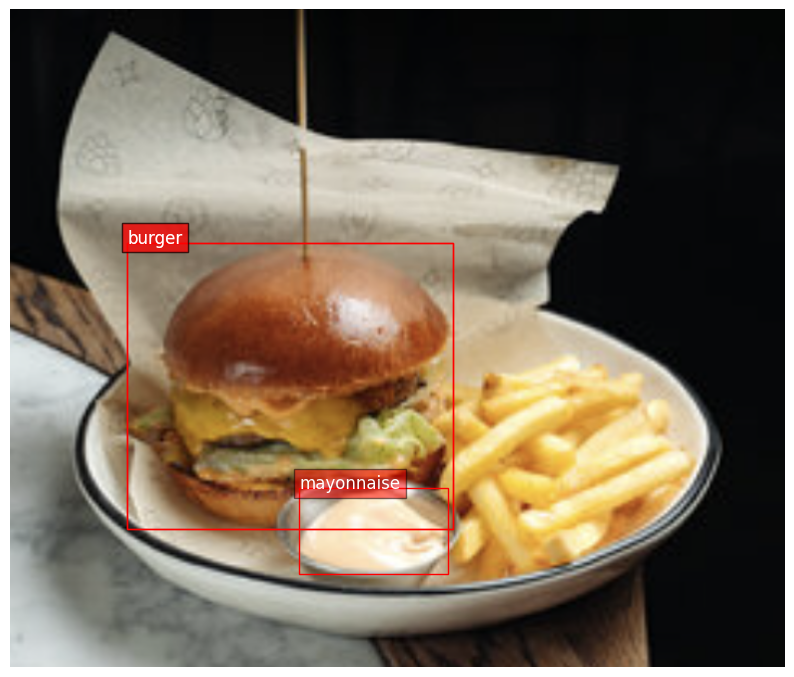

In [48]:
image = Image.open("burger.png").convert("RGB")

bboxes = detect_foods(image)
plot_bbox(image, bboxes)
labels = bboxes['labels']

In [50]:
get_nutrition(labels)

({'protein_g': 18.9, 'fat_g': 98.0, 'carbohydrates_g': 6.2},
 {'protein_g': {'burger': 18.0, 'mayonnaise': 0.9},
  'fat_g': {'burger': 20.0, 'mayonnaise': 78.0},
  'carbohydrates_g': {'burger': 3.0, 'mayonnaise': 3.2}})